# Lab 8: Some Machine Learning exploration using Gaia DR2

Let's look at a chunk of data around the young cluster "Praesepe", and see if we can pick out the most likely cluster memebers!

I would suggest using various [clustering algorithms](http://scikit-learn.org/stable/modules/clustering.html) within scikit-learn.

**IN FACT:** it would be _awesome_ to reproduce that clustering example grid using this data...!

Ways forward (e.g. things we *might* try today)
- do clustering on just the proper motions
- do clustering on proper motions AND spatial positions (RA, Dec, dist)
- do clustering on proper motions, spatial positions, AND color-magnitude diagram positions!

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

from astropy.io import fits

In [2]:
file = 'data/Praesepe_GaiaDR2.fit'
hdu = fits.open(file)
data = hdu[1].data

In [3]:
data.columns

ColDefs(
    name = 'RA_ICRS'; format = 'D'; unit = 'deg'; disp = 'F15.11'
    name = 'e_RA_ICRS'; format = 'D'; unit = 'mas'; disp = 'F7.4'
    name = 'DE_ICRS'; format = 'D'; unit = 'deg'; disp = 'F15.11'
    name = 'e_DE_ICRS'; format = 'D'; unit = 'mas'; disp = 'F7.4'
    name = 'Source'; format = 'K'; disp = 'I19'
    name = 'Plx'; format = 'D'; unit = 'mas'; disp = 'F10.4'
    name = 'e_Plx'; format = 'E'; unit = 'mas'; disp = 'F7.4'
    name = 'pmRA'; format = 'D'; unit = 'mas/yr'; disp = 'F9.3'
    name = 'e_pmRA'; format = 'E'; unit = 'mas/yr'; disp = 'F6.3'
    name = 'pmDE'; format = 'D'; unit = 'mas/yr'; disp = 'F9.3'
    name = 'e_pmDE'; format = 'E'; unit = 'mas/yr'; disp = 'F6.3'
    name = 'Dup'; format = 'B'; disp = 'I1'
    name = 'FG'; format = 'E'; unit = 'e-/s'; disp = 'E11.4'
    name = 'e_FG'; format = 'E'; unit = 'e-/s'; disp = 'E11.4'
    name = 'Gmag'; format = 'D'; unit = 'mag'; disp = 'F7.4'
    name = 'e_Gmag'; format = 'D'; unit = 'mag'; disp = 'F6.4'
    

Text(0,0.5,'$m_G$')

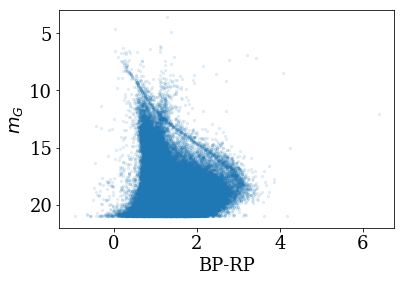

In [10]:
plt.scatter(data['BP-RP'], data['Gmag'], s=5, alpha=0.1)
plt.ylim(22,3)
plt.xlabel('BP-RP')
plt.ylabel(r'$m_G$')

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


Text(0,0.5,'$M_G$')

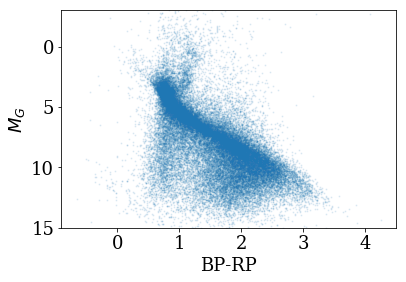

In [11]:
mu = 5 - 5*np.log10(1000./data['Plx'])
plt.scatter(data['BP-RP'], data['Gmag'] + mu, s=1, alpha=0.1)
plt.ylim(15,-3)
plt.xlabel('BP-RP')
plt.ylabel(r'$M_G$')

Text(0,0.5,'PM_Dec')

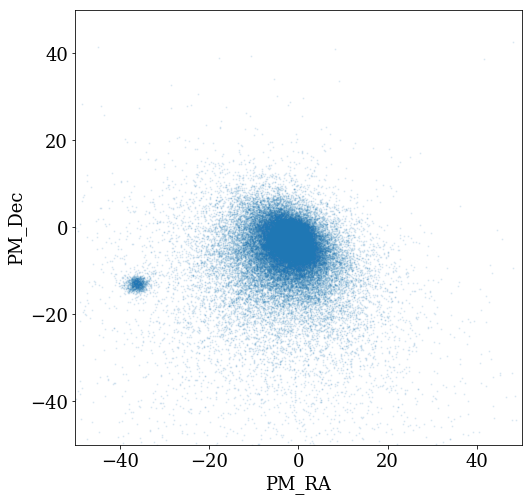

In [12]:
plt.figure(figsize=(8,8))
plt.scatter(data['pmRA'], data['pmDE'], s=1, alpha=0.1)
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.xlabel('PM_RA')
plt.ylabel('PM_Dec')

In [ ]:
# let's defintely try GMM (easiest first!)

In [24]:
from sklearn import mixture
from matplotlib.colors import LogNorm

In [119]:
ok = np.where(np.isfinite(data['pmRA']) & 
              np.isfinite(data['pmDE']) & 
              (np.abs(data['pmRA']) < 75) & 
              (np.abs(data['pmDE']) < 75))

X_train = np.vstack((data['pmRA'][ok], data['pmDE'][ok])).T
X_train.shape

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


(56004, 2)

In [120]:
clf = mixture.GaussianMixture(n_components=3, covariance_type='full', means_init=[[-35, -15], [0,-5], [-1,-7]])
clf.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=array([[-35., -15.],
       [  0.,  -5.],
       [ -1.,  -7.]]),
        n_components=3, n_init=1, precisions_init=None, random_state=None,
        reg_covar=1e-06, tol=0.001, verbose=0, verbose_interval=10,
        warm_start=False, weights_init=None)

Text(0,0.5,'PM_Dec')

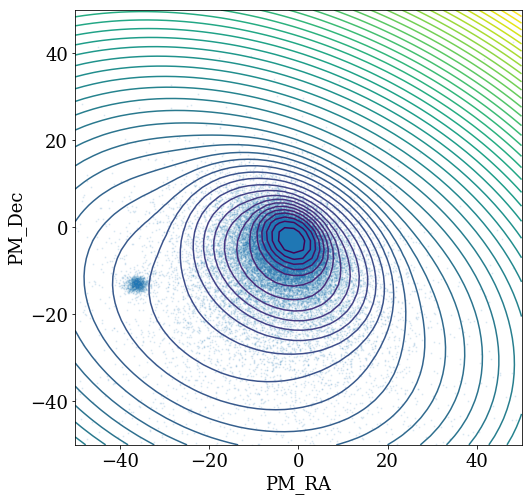

In [121]:
plt.figure(figsize=(8,8))
# display predicted scores by the model as a contour plot
x = np.linspace(-50., 50.)
y = np.linspace(-50., 50.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, levels=np.linspace(np.nanmin(Z), np.nanmax(Z), 50))

plt.scatter(X_train[:, 0], X_train[:, 1], s=1, alpha=0.1)

plt.xlim(-50,50)
plt.ylim(-50,50)
plt.xlabel('PM_RA')
plt.ylabel('PM_Dec')


In [122]:
labels = clf.predict(X_train)
labels.shape

(56004,)

Text(0,0.5,'PM_Dec')

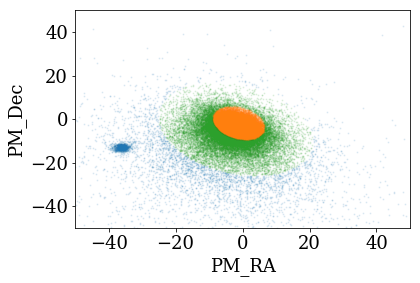

In [123]:
x0 = (labels == 0)
plt.scatter(X_train[x0, 0], X_train[x0, 1], s=1, alpha=0.1)

x1 = (labels == 1)
plt.scatter(X_train[x1, 0], X_train[x1, 1], s=1, alpha=0.1)

x2 = (labels == 2)
plt.scatter(X_train[x2, 0], X_train[x2, 1], s=1, alpha=0.1)


plt.xlim(-50,50)
plt.ylim(-50,50)
plt.xlabel('PM_RA')
plt.ylabel('PM_Dec')

In [124]:
from sklearn import cluster

db = cluster.DBSCAN(min_samples=5).fit(X_train)

In [125]:
labels = db.labels_
print(max(labels))

160


Text(0,0.5,'PM_Dec')

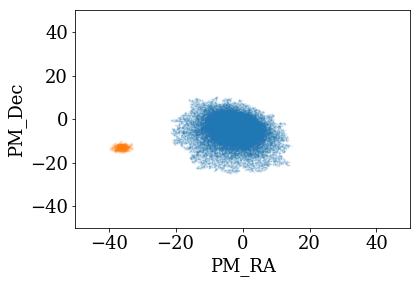

In [126]:
x0 = (labels == 0)
plt.scatter(X_train[x0, 0], X_train[x0, 1], s=1, alpha=0.1)

x1 = (labels == 1)
plt.scatter(X_train[x1, 0], X_train[x1, 1], s=1, alpha=0.1)

# x2 = (labels == 2)
# plt.scatter(X_train[x2, 0], X_train[x2, 1], s=1, alpha=0.1)


plt.xlim(-50,50)
plt.ylim(-50,50)
plt.xlabel('PM_RA')
plt.ylabel('PM_Dec')

Text(0,0.5,'$m_G$')

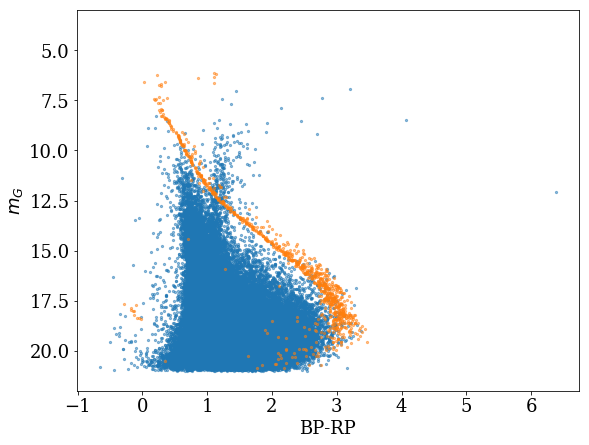

In [127]:
plt.figure(figsize=(9,7))
plt.scatter(data['BP-RP'][ok][x0], data['Gmag'][ok][x0], s=5, alpha=0.5)
plt.scatter(data['BP-RP'][ok][x1], data['Gmag'][ok][x1], s=5, alpha=0.5)
plt.ylim(22,3)
plt.xlabel('BP-RP')
plt.ylabel(r'$m_G$')